In [5]:
import argparse
import logging
import os
import sys

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split

sys.path.append("..")
sys.path.append("../scripts/")
import superlayer.utils

from scripts import eval_net, train_net, get_args

from superlayer.models import UNet, TiedUNet
from superlayer.utils import BrainD, dice_coeff, one_hot

In [2]:
dir_img = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/vols/'
dir_mask = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/asegs/'
dir_checkpoint_1 = 'checkpoints_1/'
dir_checkpoint_2 = 'checkpoints_2/'

np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(threshold=10_000)

In [3]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
args = get_args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

INFO: Using device cuda


In [4]:
target_label_numbers = [0,2,3,4,10,16,17,28,31,41,42,43,49,53,63]
val_percent = 0.1
batch_size = args.batchsize
lr = args.lr
img_scale = args.scale

dataset = BrainD(dir_img, dir_mask, label_numbers=target_label_numbers)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - 2 * n_val
n_test = n_val
train, val, test = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=8, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')

INFO: Creating dataset with 7329 examples


In [5]:
one_example = next(iter(train_loader))

image = one_example['image'][0]
mask = one_example['mask'][0]

print(image.shape)
print(mask.shape)

sq_img = image.squeeze(0).squeeze(0)
sq_msk = mask.squeeze(0).squeeze(0)

torch.Size([1, 160, 192])
torch.Size([1, 160, 192])


torch.Size([160, 192])


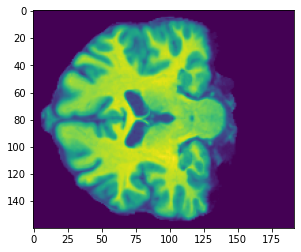

In [6]:
print(sq_img.shape)
plt.imshow(sq_img)

torch.Size([160, 192])


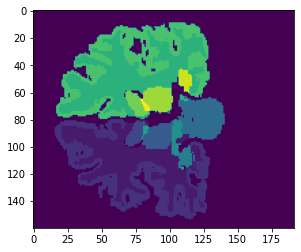

In [7]:
print(sq_msk.shape)
plt.imshow(sq_msk)

In [8]:
net1 = UNet(n_channels=1, n_classes=15, bilinear=True)

logging.info(f'Network:\n'
             f'\t{net1.n_channels} input channels\n'
             f'\t{net1.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if net1.bilinear else "Transposed conv"} upscaling')

net1.to(device=device)
train_scores1, val_scores1, train_var_1, val_var_1 = train_net(net=net1,
                                                                epochs=args.epochs,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=1,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

INFO: Network:
	1 input channels
	15 output channels (classes)
	Bilinear upscaling
INFO: Starting training:
        Epochs:          3
        Batch size:      8
        Learning rate:   0.001
        Training size:   6597
        Validation size: 732
        Checkpoints:     True
        Device:          cuda
        Images scaling:  1
    
Validation round: 100%|██████████| 91/91 [00:04<00:00, 25.52batch/s]
                                                                    INFO: Validation Dice Loss: 0.06454928743315268
Validation round: 100%|██████████| 91/91 [00:04<00:00, 25.16batch/s]
                                                                    INFO: Validation Dice Loss: 0.06046250290595568
Validation round: 100%|██████████| 91/91 [00:03<00:00, 27.51batch/s]
                                                                    INFO: Validation Dice Loss: 0.05574969587090251
Validation round: 100%|██████████| 91/91 [00:03<00:00, 27.87batch/s]
                                

Validation round: 100%|██████████| 91/91 [00:03<00:00, 27.57batch/s]
                                                                    INFO: Validation Dice Loss: 0.04654287456811129
Validation round: 100%|██████████| 91/91 [00:03<00:00, 25.68batch/s]
                                                                    INFO: Validation Dice Loss: 0.051953910798816894
Epoch 1/3:  89%|████████▉ | 5865/6597 [02:32<00:19, 38.34img/s, loss (batch)=0.0888]
INFO: Checkpoint 1 saved !
Validation round:  99%|█████████▉| 90/91 [00:03<00:00, 26.90batch/s]
                                                                    INFO: Validation Dice Loss: 0.04654455880869876
Validation round: 100%|██████████| 91/91 [00:04<00:00, 26.00batch/s]
                                                                    INFO: Validation Dice Loss: 0.04397029748984745
Validation round: 100%|██████████| 91/91 [00:04<00:00, 25.45batch/s]
                                                                    INFO: Vali

Validation round: 100%|██████████| 91/91 [00:03<00:00, 26.20batch/s]
                                                                    INFO: Validation Dice Loss: 0.04076369450642513
Validation round: 100%|██████████| 91/91 [00:03<00:00, 26.45batch/s]
                                                                    INFO: Validation Dice Loss: 0.04337006307892747
Validation round: 100%|██████████| 91/91 [00:03<00:00, 27.29batch/s]
                                                                    INFO: Validation Dice Loss: 0.040796582597297626
Validation round: 100%|██████████| 91/91 [00:04<00:00, 26.82batch/s]
                                                                    INFO: Validation Dice Loss: 0.043087788826816686
Epoch 2/3:  89%|████████▉ | 5865/6597 [02:37<00:19, 37.28img/s, loss (batch)=0.0848]
INFO: Checkpoint 2 saved !
Validation round: 100%|██████████| 91/91 [00:04<00:00, 27.08batch/s]
                                                                    INFO: Val

Validation round: 100%|██████████| 91/91 [00:03<00:00, 26.24batch/s]
                                                                    INFO: Validation Dice Loss: 0.038433282175561884
Validation round: 100%|██████████| 91/91 [00:03<00:00, 27.23batch/s]
                                                                    INFO: Validation Dice Loss: 0.03838553844572424
Validation round: 100%|██████████| 91/91 [00:03<00:00, 26.60batch/s]
                                                                    INFO: Validation Dice Loss: 0.03847820066161208
Validation round: 100%|██████████| 91/91 [00:03<00:00, 26.73batch/s]
                                                                    INFO: Validation Dice Loss: 0.038325838662765836
Validation round: 100%|██████████| 91/91 [00:04<00:00, 26.53batch/s]
                                                                    INFO: Validation Dice Loss: 0.0383705551643948
Epoch 3/3:  89%|████████▉ | 5865/6597 [02:37<00:19, 37.28img/s, loss (batc

In [9]:
net2 = TiedUNet(n_channels=1, n_classes=15, bilinear=True)

logging.info(f'Network:\n'
             f'\t{net2.n_channels} input channels\n'
             f'\t{net2.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if net2.bilinear else "Transposed conv"} upscaling')

net2.to(device=device)
train_scores2, val_scores2, train_var_2, val_var_2 = train_net(net=net2,
                                                                epochs=args.epochs,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=2,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

INFO: Network:
	1 input channels
	15 output channels (classes)
	Bilinear upscaling
INFO: Starting training:
        Epochs:          3
        Batch size:      8
        Learning rate:   0.001
        Training size:   6597
        Validation size: 732
        Checkpoints:     True
        Device:          cuda
        Images scaling:  1
    
Validation round:  98%|█████████▊| 89/91 [00:03<00:00, 21.94batch/s]
                                                                    INFO: Validation Dice Loss: 0.4495948605485015
Validation round:  99%|█████████▉| 90/91 [00:03<00:00, 28.91batch/s]
                                                                    INFO: Validation Dice Loss: 0.45588291444621243
Validation round:  98%|█████████▊| 89/91 [00:03<00:00, 24.57batch/s]
                                                                    INFO: Validation Dice Loss: 0.6144524812698364
Validation round: 100%|██████████| 91/91 [00:03<00:00, 27.15batch/s]
                                  

Validation round: 100%|██████████| 91/91 [00:04<00:00, 25.49batch/s]
                                                                    INFO: Validation Dice Loss: 0.7504419841609158
Validation round: 100%|██████████| 91/91 [00:03<00:00, 27.19batch/s]
                                                                    INFO: Validation Dice Loss: 0.7447951756990873
Validation round:  98%|█████████▊| 89/91 [00:03<00:00, 25.01batch/s]
                                                                    INFO: Validation Dice Loss: 0.7472610349183554
Validation round: 100%|██████████| 91/91 [00:03<00:00, 27.61batch/s]
                                                                    INFO: Validation Dice Loss: 0.7540039963774628
Validation round: 100%|██████████| 91/91 [00:03<00:00, 29.71batch/s]
                                                                    INFO: Validation Dice Loss: 0.7520450360172397
Validation round:  98%|█████████▊| 89/91 [00:04<00:00, 22.04batch/s]
           

Validation round:  98%|█████████▊| 89/91 [00:03<00:00, 26.06batch/s]
                                                                    INFO: Validation Dice Loss: 0.7528136451165754
Validation round:  98%|█████████▊| 89/91 [00:03<00:00, 21.90batch/s]
                                                                    INFO: Validation Dice Loss: 0.7558037527314909
Validation round:  98%|█████████▊| 89/91 [00:03<00:00, 27.32batch/s]
                                                                    INFO: Validation Dice Loss: 0.745031978402819
Validation round: 100%|██████████| 91/91 [00:03<00:00, 26.01batch/s]
                                                                    INFO: Validation Dice Loss: 0.7458333039021754
Validation round:  98%|█████████▊| 89/91 [00:04<00:00, 22.77batch/s]
                                                                    INFO: Validation Dice Loss: 0.763622101846632
Validation round:  98%|█████████▊| 89/91 [00:04<00:00, 21.71batch/s]
             

configuring plot one


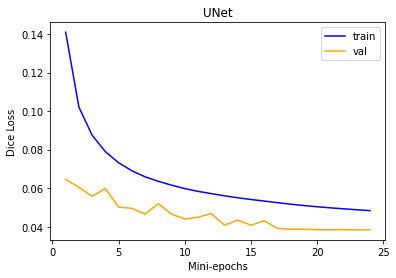

In [10]:
print("configuring plot one")
domain = len(train_scores1)
x_values = [i+1 for i in range(domain)]
plt.title("UNet")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores1, color="blue", label="train")
plt.plot(x_values, val_scores1, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

configuring plot two


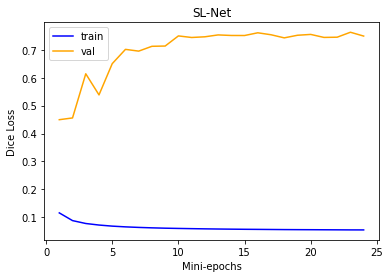

In [11]:
print("configuring plot two")
domain = len(train_scores2)
x_values = [i+1 for i in range(domain)]
plt.title("SL-Net")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores2, color="blue", label="train")
plt.plot(x_values, val_scores2, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

In [12]:
import math

# Create another simulation dataset for test
train_loader = DataLoader(train, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
val_loader = DataLoader(val, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
test_loader = DataLoader(test, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

# Get the first batch
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))
test_batch = next(iter(test_loader))

inputs_train = train_batch['image']
labels_train = train_batch['mask']

inputs_val = val_batch['image']
labels_val = val_batch['mask']

inputs_test = test_batch['image']
labels_test = test_batch['mask']

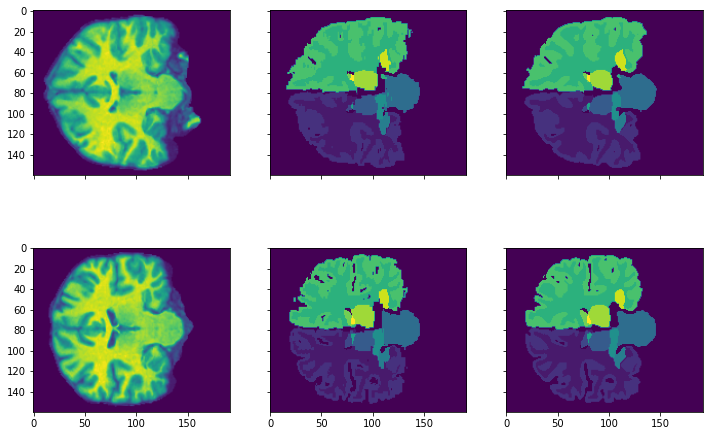

In [13]:
net1.eval() 
inputs = inputs_train.to(device=device, dtype=torch.float32)
labels = labels_train.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

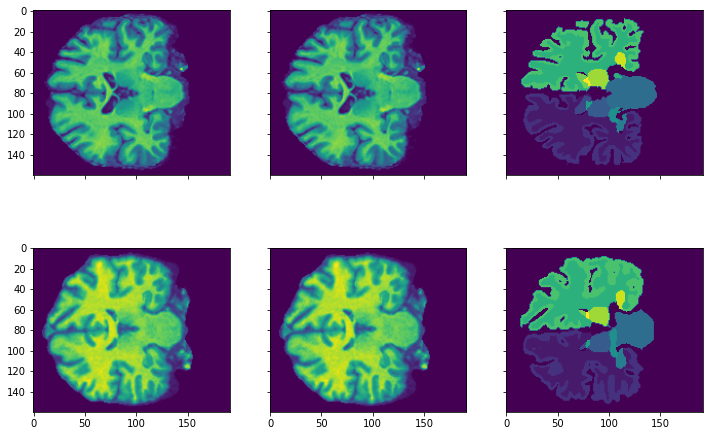

In [14]:
net1.eval() 
inputs = inputs_val.to(device=device, dtype=torch.float32)
labels = inputs_val.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

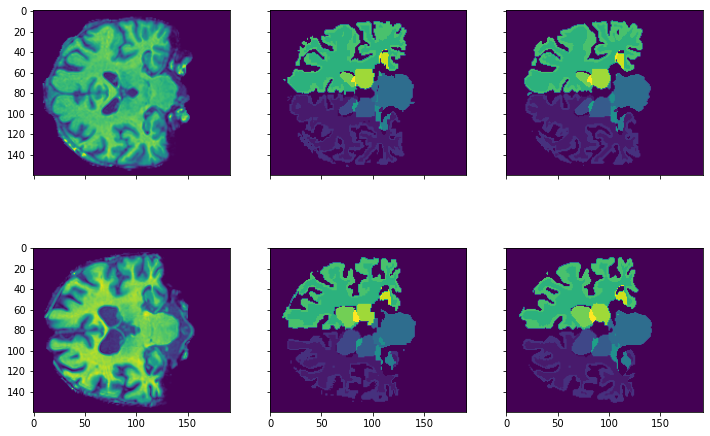

In [15]:
net1.eval() 
inputs = inputs_test.to(device=device, dtype=torch.float32)
labels = labels_test.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

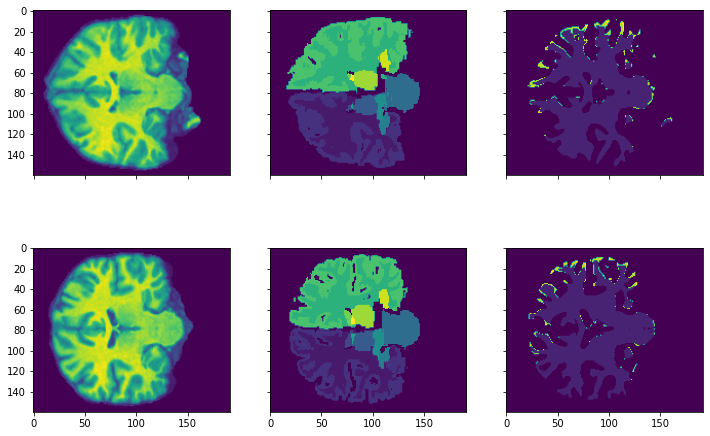

In [16]:
net2.eval()
inputs = inputs_train.to(device=device, dtype=torch.float32)
labels = labels_train.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

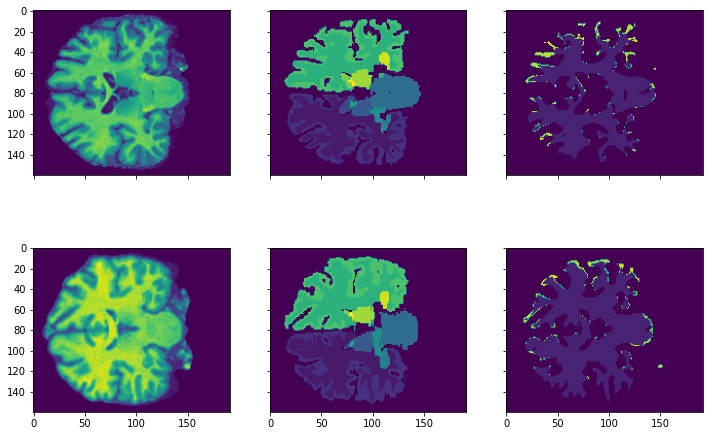

In [17]:
net2.eval()
inputs = inputs_val.to(device=device, dtype=torch.float32)
labels = labels_val.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

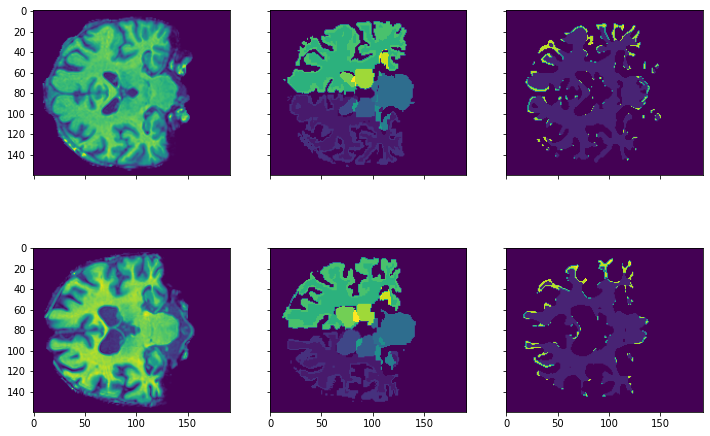

In [18]:
net2.eval()
inputs = inputs_test.to(device=device, dtype=torch.float32)
labels = labels_test.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])